# Volatility Timing
## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand the volatility timing logic** — Why scaling by inverse variance improves risk-adjusted returns
2. **Construct realized variance from daily data** — Aggregate daily returns to monthly variance estimates
3. **Build volatility-managed portfolios** — Create weights inversely proportional to recent volatility
4. **Evaluate the strategy empirically** — Test if the price of risk declines with volatility
5. **Apply volatility timing to multiple factors** — Extend the approach beyond just the market

## 📋 Table of Contents

1. [Setup](#setup)
2. [The Volatility Timing Logic](#volatility-logic)
3. [Constructing Realized Variance](#realized-variance)
4. [Does Volatility Predict the Price of Risk?](#price-of-risk)
5. [Building the Strategy](#building-strategy)
6. [Performance Evaluation](#performance)
7. [Exercises](#exercises)
8. [Key Takeaways](#key-takeaways)

---

## 🛠️ Setup <a id="setup"></a>

In [1]:
#@title 🛠️ Setup: Run this cell first (click to expand)

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pandas-datareader: Fetches financial data from online sources
from pandas_datareader import data as DataReader

# Set consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
#@title Helper Function: Get Factor Data

def get_factors(factors='CAPM', freq='daily'):
    """
    Fetch Fama-French factor data from Ken French's website.

    Parameters:
    -----------
    factors : str
        'CAPM', 'FF3', 'FF5', or 'FF6'
    freq : str
        'daily' or 'monthly'
    """
    freq_label = '' if freq == 'monthly' else '_' + freq

    if factors == 'CAPM':
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF']]
    elif factors == 'FF3':
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
    elif factors == 'FF5':
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader.DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}",
                                    "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
    else:  # FF6
        ff = DataReader.DataReader(f"F-F_Research_Data_Factors{freq_label}",
                                   "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader.DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}",
                                    "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
        mom = DataReader.DataReader(f"F-F_Momentum_Factor{freq_label}",
                                    "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(mom[0], on='Date')
        df_factor.columns = ['RF', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

    if freq == 'monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)

    return df_factor / 100

---

## The Volatility Timing Logic <a id="volatility-logic"></a>

### The Optimal Allocation Formula

Recall the mean-variance optimal weight:

$$x_t = \frac{E_t[r^e_{t+1}]}{\gamma \cdot \text{Var}_t(r^e_{t+1})}$$

Two extreme cases:

| Case | Formula                         | Strategy |
|------|---------------------------------|----------|
| Constant variance | $$x_t = \frac{E_t[r^e]}{\gamma \sigma^2}$$ | Time expected returns |
| Constant expected returns | $$x_t = \frac{\mu}{\gamma \cdot \text{Var}_t}$$ | Time variance |

### When Does Volatility Timing Work?

Suppose expected returns relate to variance as:

$$E_t[r^e_{t+1}] = a + b \cdot \text{Var}_t(r^e_{t+1})$$

Then the optimal weight becomes:

$$x_t = \frac{a + b \cdot \text{Var}_t}{\gamma \cdot \text{Var}_t} = \frac{a}{\gamma \cdot \text{Var}_t} + \frac{b}{\gamma}$$

> **💡 Key Insight:**
>
> - If $a = 0$ (expected returns proportional to variance): No benefit from vol timing
> - If $b = 0$ (expected returns constant): Maximum benefit from vol timing
> - Reality is somewhere in between, but closer to $b = 0$ for most factors

> **📌 Remember:**
>
> This only works if the factor has positive alpha/premium to begin with.
> If the Sharpe ratio is zero, you can't increase it by managing risk!

---

## Constructing Realized Variance <a id="realized-variance"></a>

### Loading Daily Factor Data

In [3]:
# Get daily factor data
df_factor = get_factors('CAPM', freq='daily')

print(f"Data range: {df_factor.index.min().date()} to {df_factor.index.max().date()}")
df_factor.head()

Data range: 1926-07-01 to 2025-11-28


,RF,Mkt-RF
Date,,
1926-07-01,0.0001,0.0009
1926-07-02,0.0001,0.0045
1926-07-06,0.0001,0.0017
1926-07-07,0.0001,0.0009
1926-07-08,0.0001,0.0022


### Computing Monthly Realized Variance

We estimate variance using daily returns within each month:

$$RV_t = \sum_{d \in \text{days in month } t} \frac{(r_d - \bar{r})^2}{N_{\text{days}}}$$

This gives us a **forward-looking** volatility estimate based on recent data.

> **🐍 Python Insight: `groupby()`**
>
> The pandas `groupby()` method is one of the most powerful tools for data analysis. It follows the **Split → Apply → Combine** pattern:
>
> ```python
> df.groupby(grouping_key).aggregate_function()
> ```
>
> | Step | Action | Example |
> |------|--------|---------|
> | **Split** | Divide data into groups | `df.groupby(df.index.year)` |
> | **Apply** | Apply function to each group | `.mean()`, `.sum()`, `.prod()` |
> | **Combine** | Merge results back together | Returns one row per group |
>
> We'll use this extensively throughout the course!

In [4]:
# Compute monthly realized variance (annualized)
RV = df_factor[['Mkt-RF']].groupby(
    df_factor.index + pd.offsets.MonthEnd(0)
).var() * 252

RV = RV.rename(columns={'Mkt-RF': 'RV'})

# Aggregate daily returns to monthly
Ret = (1 + df_factor).groupby(
    df_factor.index + pd.offsets.MonthEnd(0)
).prod() - 1

# Merge variance and returns
df = RV.merge(Ret, how='left', left_index=True, right_index=True)

# Lag variance by one month (we use last month's variance to form today's weights)
df['RV_lag'] = df['RV'].shift(1)

print(f"Average annualized variance: {df['RV'].mean():.4f}")
print(f"Average annualized volatility: {np.sqrt(df['RV'].mean()):.2%}")

Average annualized variance: 0.0287
Average annualized volatility: 16.96%


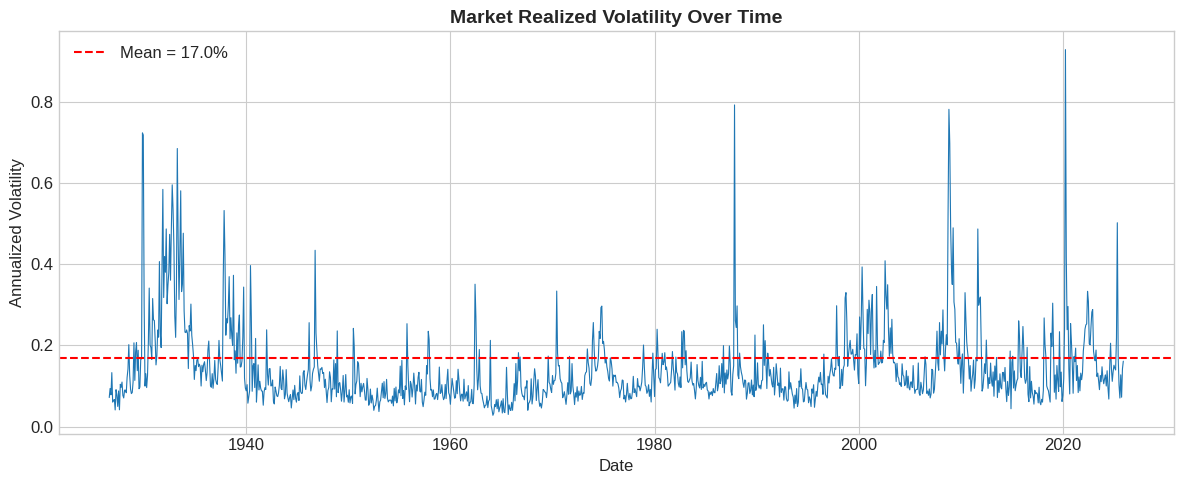

In [5]:
# Visualize realized volatility over time
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df.index, np.sqrt(df['RV']), linewidth=0.8)
ax.axhline(np.sqrt(df['RV'].mean()), color='red', linestyle='--',
           label=f'Mean = {np.sqrt(df["RV"].mean()):.1%}')

ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility')
ax.set_title('Market Realized Volatility Over Time', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

---

## Does Volatility Predict the Price of Risk? <a id="price-of-risk"></a>

### The Key Test

For volatility timing to work, we need:

$$\text{Cov}\left(RV_t, \frac{r^e_{t+1}}{RV_{t+1}}\right) < 0$$

Translation: When volatility is high, the **risk-return tradeoff worsens**.

If a=0  this will not happen

In [6]:
# Sort months into quintiles by lagged volatility
df['Quantile'] = pd.qcut(df['RV_lag'], q=5, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'])

# Compute means by quintile
quantile_stats = df.groupby('Quantile').agg({
    'RV': 'mean',
    'Mkt-RF': 'mean'
})

# Compute price of risk (return per unit variance)
quantile_stats['Price_of_Risk'] = quantile_stats['Mkt-RF'] * 12 / quantile_stats['RV']
quantile_stats['Vol_t1'] = np.sqrt(quantile_stats['RV'])
quantile_stats['Return_t1'] = quantile_stats['Mkt-RF'] * 12

quantile_stats

,RV,Mkt-RF,Price_of_Risk,Vol_t1,Return_t1
Quantile,,,,,
Q1 (Low),0.008515,0.006555,9.237906,0.092278,0.078663
Q2,0.012690,0.007419,7.015934,0.112651,0.089034
Q3,0.015370,0.004989,3.895362,0.123977,0.059873
Q4,0.029784,0.007048,2.839784,0.172579,0.084579
Q5 (High),0.077360,0.008520,1.321600,0.278137,0.102239


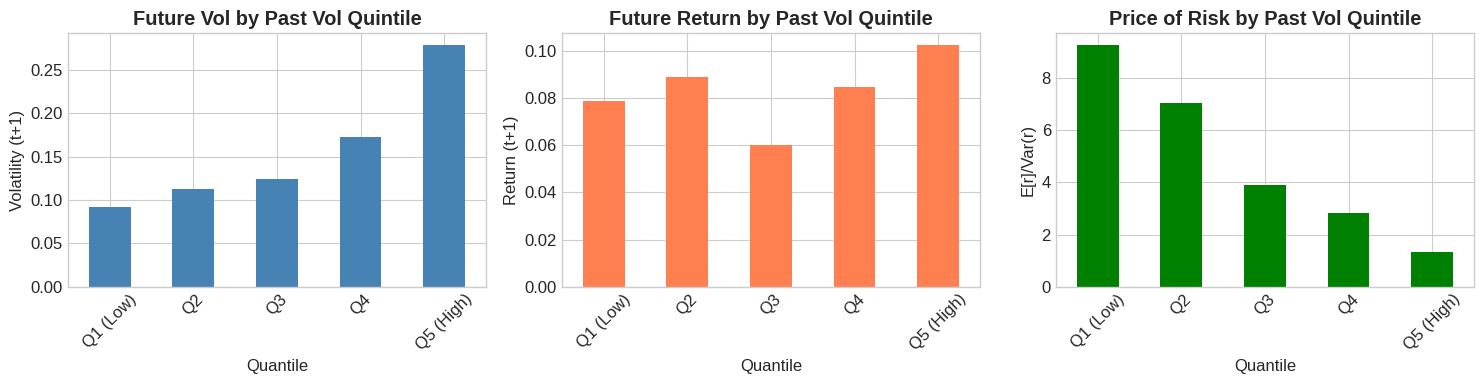

In [7]:
# Visualize the pattern
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Volatility by quintile
quantile_stats['Vol_t1'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Future Vol by Past Vol Quintile', fontweight='bold')
axes[0].set_ylabel('Volatility (t+1)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Returns by quintile
quantile_stats['Return_t1'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Future Return by Past Vol Quintile', fontweight='bold')
axes[1].set_ylabel('Return (t+1)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Price of risk by quintile
quantile_stats['Price_of_Risk'].plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title('Price of Risk by Past Vol Quintile', fontweight='bold')
axes[2].set_ylabel('E[r]/Var(r)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

> **💡 Key Insight:**
>
> Returns are roughly **flat** across volatility quintiles, but volatility
> varies dramatically. This means the **price of risk** (return per unit variance)
> is much higher when volatility is low.
>
> Strategy: Lever up when vol is low, reduce exposure when vol is high.

---

## Building the Strategy <a id="building-strategy"></a>

### From Signal to Weights

The volatility-managed strategy uses weights:

$$w_t = \frac{c}{RV_t}$$

where $c$ is chosen so that the average weight equals 1:

$$c = \frac{1}{E\left[\frac{1}{RV_t}\right]}$$

In [8]:
# Compute weights
df['Weight_raw'] = 1 / df['RV_lag']
c = 1 / df['Weight_raw'].mean()
df['Weight'] = c * df['Weight_raw']

print(f"Scaling constant c: {c:.6f}")
print(f"Average weight: {df['Weight'].mean():.2f}")

Scaling constant c: 0.009074
Average weight: 1.00


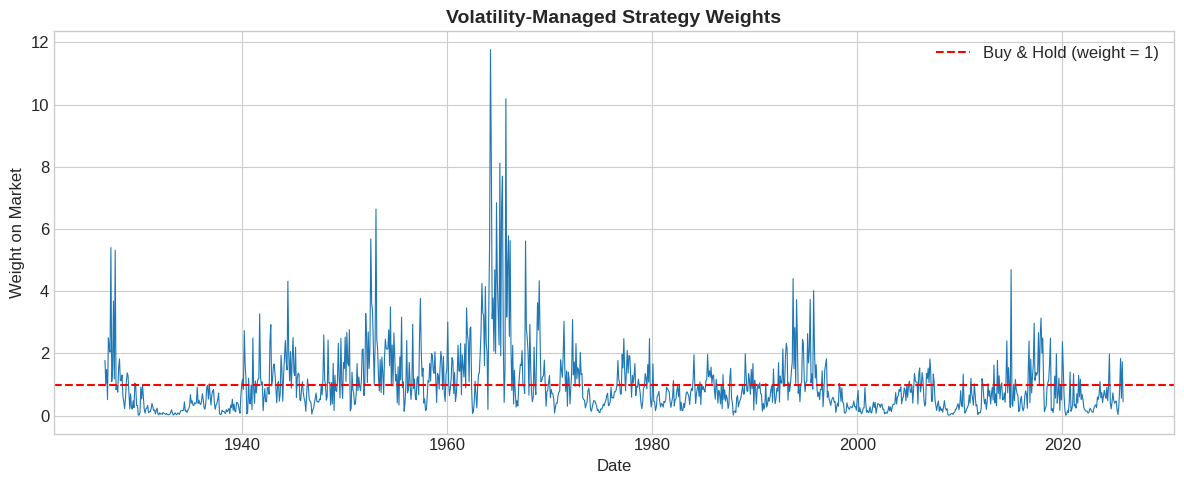

In [9]:
# Visualize weights over time
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df.index, df['Weight'], linewidth=0.8)
ax.axhline(1, color='red', linestyle='--', label='Buy & Hold (weight = 1)')

ax.set_xlabel('Date')
ax.set_ylabel('Weight on Market')
ax.set_title('Volatility-Managed Strategy Weights', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

> **⚠️ Caution:**
>
> Leverage can get extreme! Weights can exceed 10x during calm periods.
> In practice, you'd want leverage limits.

### Strategy Returns

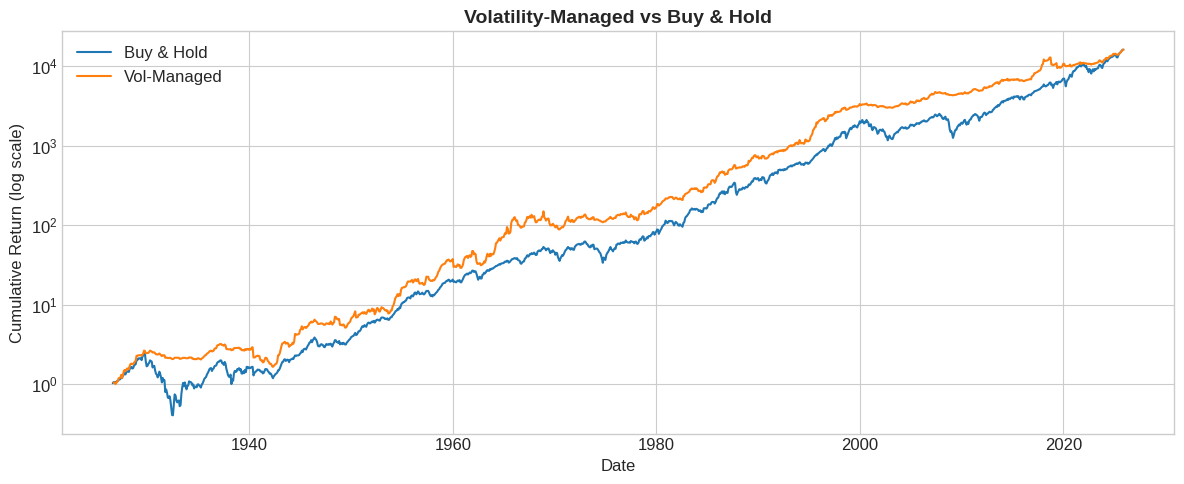

In [10]:
# Compute strategy returns
df['VMS'] = df['Weight'] * df['Mkt-RF']

# Cumulative returns comparison
fig, ax = plt.subplots(figsize=(12, 5))

cum_mkt = (1 + df['RF'] + df['Mkt-RF']).cumprod()
cum_vms = (1 + df['RF'] + df['VMS']).cumprod()

ax.plot(df.index, cum_mkt, label='Buy & Hold', linewidth=1.5)
ax.plot(df.index, cum_vms, label='Vol-Managed', linewidth=1.5)

ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return (log scale)')
ax.set_title('Volatility-Managed vs Buy & Hold', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

---

## Performance Evaluation <a id="performance"></a>

- you end up in the same place. Does that mean that we didn't accomplish anything?

- Stear at the picture--what do you see?

### Sharpe Ratio Comparison

In [11]:
# Sharpe ratios (annualized)
sr_mkt = (df['Mkt-RF'].mean() / df['Mkt-RF'].std()) * np.sqrt(12)
sr_vms = (df['VMS'].mean() / df['VMS'].std()) * np.sqrt(12)

print(f"Sharpe Ratio (Buy & Hold): {sr_mkt:.3f}")
print(f"Sharpe Ratio (Vol-Managed): {sr_vms:.3f}")
print(f"Improvement: {(sr_vms / sr_mkt - 1):.1%}")

Sharpe Ratio (Buy & Hold): 0.452
Sharpe Ratio (Vol-Managed): 0.520
Improvement: 15.0%


### Wrapping into a Function

Let's create a reusable function for volatility management:

In [25]:
def vol_managed_portfolio(factor_returns):
    """
    Construct a volatility-managed portfolio.

    Parameters:
    -----------
    factor_returns : pd.Series
        Daily factor returns
    max_leverage : float, optional
        Maximum allowed leverage (e.g., 3.0)

    Returns:
    --------
    df : DataFrame with returns and weights
    sr_managed : Sharpe ratio of managed strategy
    sr_unmanaged : Sharpe ratio of buy-and-hold
    """
    factor_name = factor_returns.name
    factor_returns = factor_returns.dropna()

    # Compute monthly realized variance
    end_of_month = factor_returns.index + pd.offsets.MonthEnd(0)
    RV = factor_returns.groupby(end_of_month).var() * 252

    # Aggregate to monthly returns
    monthly_ret = (1 + factor_returns).groupby(end_of_month).prod() - 1

    # Merge and lag
    df = pd.DataFrame({'RV': RV, factor_name: monthly_ret})
    df['RV_lag'] = df['RV'].shift(1)

    # Compute weights
    df['signal'] = 1 / df['RV_lag']
    df['Weight'] = df['signal'] / df['signal'].mean()


    # Compute managed returns
    df[f'{factor_name}_managed'] = df['Weight'] * df[factor_name]

    # Sharpe ratios
    sr_managed = (df[f'{factor_name}_managed'].mean() / df[f'{factor_name}_managed'].std()) * np.sqrt(12)
    sr_unmanaged = (df[factor_name].mean() / df[factor_name].std()) * np.sqrt(12)
    ((df[[factor_name,f'{factor_name}_managed']]+1).cumprod()-1).plot(logy=True)
    return df, sr_managed, sr_unmanaged

No leverage cap:
  Unmanaged SR: 0.452
  Managed SR:   0.520


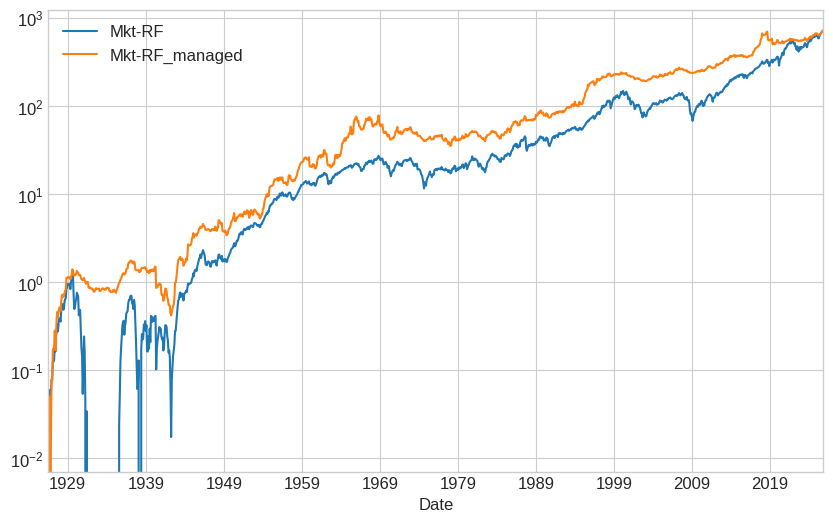

In [27]:
# Test with leverage cap
df_factor_daily = get_factors('CAPM', freq='daily')
strategy_name='Mkt-RF'
# Without cap
df, sr_managed, sr_unmanaged = vol_managed_portfolio(df_factor_daily[strategy_name])
print(f"No leverage cap:")
print(f"  Unmanaged SR: {sr_unmanaged:.3f}")
print(f"  Managed SR:   {sr_managed:.3f}")



---

## Exercises <a id="exercises"></a>

### 🔧 Exercise 1: Apply to all Factors in FF6

Apply volatility timing to Mometum factor.

1. Load daily FF6 factor data
2. Run `vol_managed_portfolio` on MOM
3. Compare Sharpe ratio improvements

<details>
<summary>💡 Click for solution</summary>

```python
df_ff = get_factors('FF6', freq='daily')

##Complete ___
for factor in ___:
    _, sr_m, sr_u = vol_managed_portfolio(df_ff[___])
    print(f"{factor}: Unmanaged = {sr_u:.3f}, Managed = {sr_m:.3f}, Δ = {sr_m - sr_u:.3f}")
```


</details>

In [ ]:
# Your code here

### 🔧 Exercise 2: Implement Leverage Limits

Modify the function to cap leverage at different levels.

1. Test caps at 2x, 3x, 5x, and unlimited
2. Plot Sharpe ratio vs leverage cap

<details>
<summary>💡 Click for solution</summary>

```python
caps = [2, 3, 5, 10, None]
srs = []


# You ahve to modify vol_managed_portfolio so this works
for cap in caps:
    _, sr, _ = vol_managed_portfolio(df_factor_daily['Mkt-RF'], max_leverage=cap)
    srs.append(sr)
    cap_str = str(cap) if cap else 'None'
    print(f"Cap = {cap_str}: SR = {sr:.3f}")

plt.figure(figsize=(8, 5))
plt.plot([str(c) if c else 'None' for c in caps], srs, 'o-')
plt.xlabel('Leverage Cap')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs Leverage Cap')
plt.show()
```

Higher caps allow more benefit but increase tail risk.

</details>

In [ ]:
# Your code here

### 🤔 Exercise 3: Volatility vs Variance Scaling

If expected returns are proportional to volatility (not variance):

$$E[r^e_{t+1}] = k \cdot \sigma_t$$


Recall optimal weights are

$$\frac{E_t[r^e_{t+1}]}{Var_t[r^e_{t+1}]} = \frac{k \cdot \sigma_t}{\sigma^2_t}=k/\sigma_t$$
Then optimal weights are $w_t \propto 1/\sigma_t$ instead of $1/\sigma_t^2$.

1. Implement vol-scaling (use $1/\sqrt{RV}$ instead of $1/RV$)
2. Compare Sharpe ratios
3. Which works better for the market?

<details>
<summary>💡 Click for solution</summary>

```python
# Variance scaling
df['Weight_var'] = 1 / df['RV_lag']
df['Weight_var'] /= df['Weight_var'].mean()

# Volatility scaling
df['Weight_vol'] = 1 / np.sqrt(df['RV_lag'])
df['Weight_vol'] /= df['Weight_vol'].mean()

# Compute returns
df['VMS_var'] = df['Weight_var'] * df['Mkt-RF']
df['VMS_vol'] = df['Weight_vol'] * df['Mkt-RF']

# Compare
sr_var = df['VMS_var'].mean() / df['VMS_var'].std() * np.sqrt(12)
sr_vol = df['VMS_vol'].mean() / df['VMS_vol'].std() * np.sqrt(12)

print(f"Variance scaling SR: {sr_var:.3f}")
print(f"Volatility scaling SR: {sr_vol:.3f}")
```

</details>

In [ ]:
# Your code here

---

## 📝 Key Takeaways <a id="key-takeaways"></a>

- **Predicting variance is much easier than predicting returns.** Past volatility strongly predicts future volatility.

- **If variance doesn't predict returns, vol timing works.** Invest more when vol is low, less when vol is high.

- **The price of risk declines with volatility.** Average returns are roughly flat across vol regimes, so risk-adjusted returns are higher in calm periods.

- **Vol timing improves Sharpe ratios for most factors.** This has been documented extensively since Moreira & Muir (2017).

- **Leverage can get extreme.** Use caps or alternative scaling to keep positions reasonable.

- **Pod funds aggressively de-risk when vol spikes.** If risk doesn't predict returns, why take it?

- **Bonus question:** What happens if everyone follows this advice? 🤔